# Time Series Analysis

In this notebook we study the time series and develop two variables:
    
`poisson_hour:`


`poisson_day:`
    

# Part 0: Library loading and function definitions.

In [4]:

from statsmodels.tsa.stattools import adfuller
import pandas as pd
# read data into a DataFrame
import pandas as pd
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances
pd.set_option('display.max_columns', 500)
%matplotlib inline

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [5]:
df_ts = pd.read_csv('../data/full_dataset_timefixed.tsv',sep='\t')

/Users/dgoldma1/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
ts = df_ts.groupby('FlightDate')['DepDelay_pos'].mean()

# Auto Correlation

In this section we look at the auto correlation of the time series to understand if there is
any seasonaility in the data.

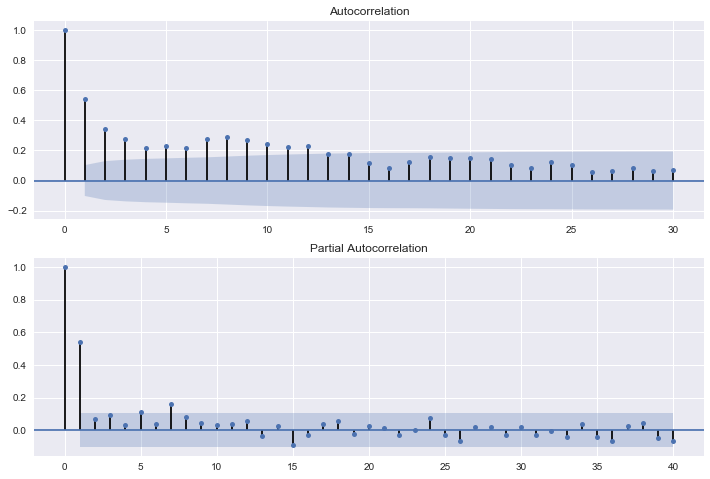

In [22]:
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)

# Stationarity

## By day

As the above plot suggests, by subtracting off a lag of 6, we get stationaryity of the difference with p value of 0.004

/Users/dgoldma1/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/Users/dgoldma1/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


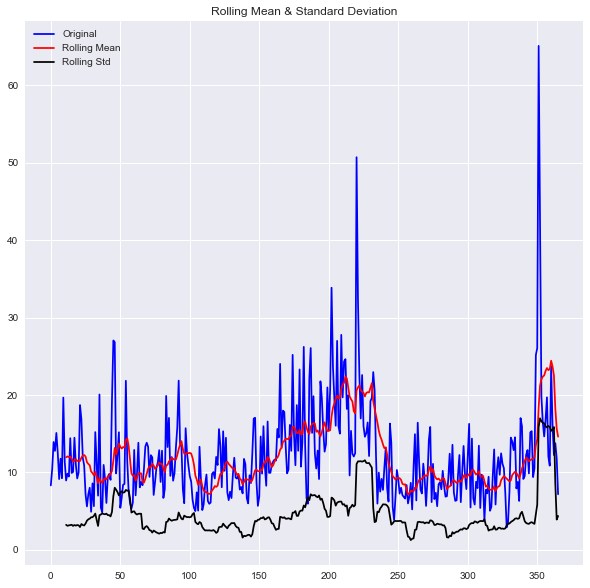

Results of Dickey-Fuller Test:
Test Statistic                  -3.687084
p-value                          0.004299
#Lags Used                       7.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


In [23]:
plt.figure(figsize=(10,10))
test_stationarity(ts.values)

## By hour

In [18]:
def make_hour(x):
    return str(x).split(' ')[1].split(':')[0]
df_ts['hour']=df_ts['CRSDepTime'].apply(lambda x : make_hour(x))

In [25]:
ts = df_ts.groupby(['FlightDate','hour'])['DepDelay_pos'].mean()

/Users/dgoldma1/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/Users/dgoldma1/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


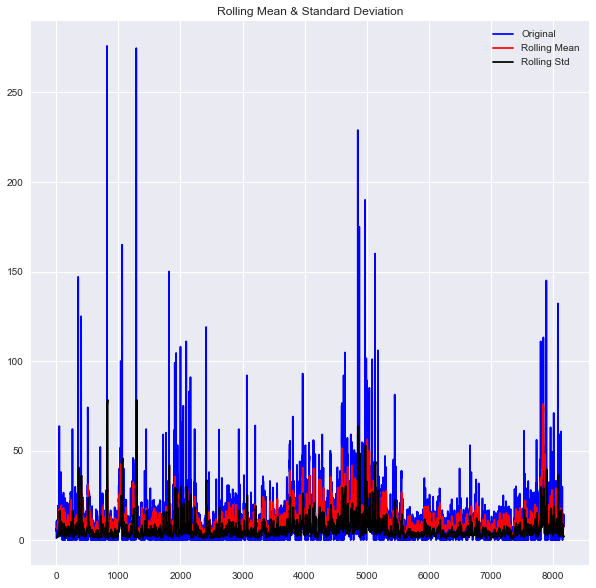

Results of Dickey-Fuller Test:
Test Statistic                -9.107770e+00
p-value                        3.465101e-15
#Lags Used                     3.700000e+01
Number of Observations Used    8.142000e+03
Critical Value (1%)           -3.431153e+00
Critical Value (5%)           -2.861895e+00
Critical Value (10%)          -2.566959e+00
dtype: float64


In [26]:
plt.figure(figsize=(10,10))
test_stationarity(ts.values)

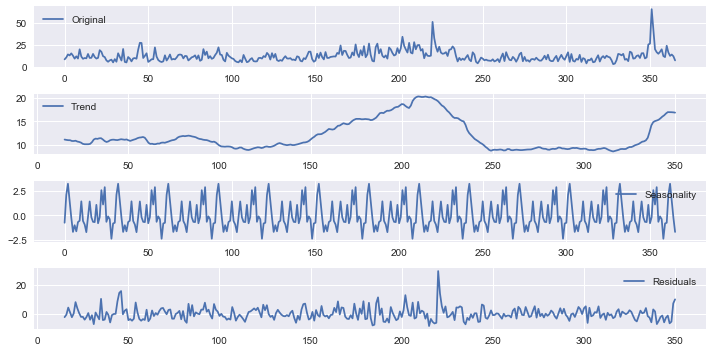

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log=ts.values
decomposition = seasonal_decompose(ts.values,freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Poisson Regression

In [28]:
ts.head()

FlightDate  hour
2016-01-01  00       1.090909
            01       4.000000
            02      10.500000
            05       4.727273
            06       6.712838
Name: DepDelay_pos, dtype: float64

In [ ]:
df_ts['DepDelay_lag1']=df_ts['DepDelay'].shift()
df_ts.drop(['DepDelay_y'],1)
df_ts.fillna(0,inplace=True)


Name : gp
Objective : 403.5314376050154
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


 /Users/dgoldma1/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


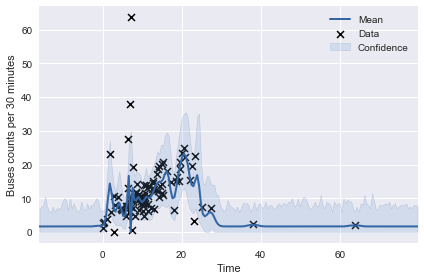

In [31]:
import GPy

kernel = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()
X = ts.shift().fillna(0).values[0:100][:,None]
#Y = df_ts['DepDelay'].values[0:100][:,None]
Y=np.array([[intensity for intensity in ts.values[0:100]]]).T

m = GPy.core.GP(X=X, Y=Y, likelihood=poisson_likelihood, inference_method=laplace_inf, kernel=kernel)
print (m)

#Predictions of counts of buses, including noise arising from Poisson noise
m.plot()
plt.xlabel('Time')
plt.ylabel('Buses counts per 30 minutes')

# Guassian regression


Name : gp
Objective : 3224.024990312931
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


 /Users/dgoldma1/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


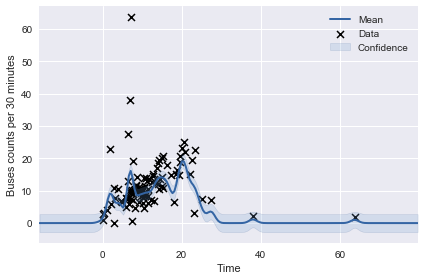

In [32]:
import GPy

kernel = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)
gaussian_likelihood = GPy.likelihoods.Gaussian()
laplace_inf = GPy.inference.latent_function_inference.Laplace()
X = ts.shift().fillna(0).values[0:100][:,None]

Y=np.array([[intensity for intensity in ts.values[0:100]]]).T

m = GPy.core.GP(X=X, Y=Y, likelihood=gaussian_likelihood, inference_method=laplace_inf, kernel=kernel)
print (m)

#Predictions of counts of buses, including noise arising from Poisson noise
m.plot()
plt.xlabel('Time')
plt.ylabel('Buses counts per 30 minutes')

In [48]:
df_test.to_csv('../data/hourly_mean_prediction.tsv',sep='\t',index=False)

In [36]:
preds=m.predict(ts.fillna(0).values[:,None])[0][:,]
actual = ts.values

preds=np.squeeze(preds)
df_test = pd.DataFrame({"date":ts.index.values,"actual":actual,"prediction":preds})

In [38]:
import re
df_test['day']=df_test['date'].apply(lambda x : re.sub("-","",x[0]))

In [39]:
df_test['hour']=df_test['date'].apply(lambda x : re.sub("-","",x[1]))

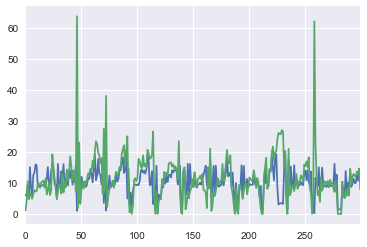

In [45]:
df_test['prediction'][0:300].plot()
df_test['actual'][0:300].plot()